# 2. Preprocessing & Feature Engineering

In [10]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

## ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, log_loss, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

## Algorithms
from sklearn.linear_model import LogisticRegression


In [11]:
telco = pd.read_csv('./data/telco_churn_data.csv')
telco = telco.set_index('Customer ID')

# replacing the null values in Offer and internet type with "none" string
telco["Offer"] = telco["Offer"].fillna("None")
telco["Internet Type"] = telco["Internet Type"].fillna("None")

telco.head()

,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,...,Latitude,Longitude,Population,Churn Value,CLTV,Churn Category,Churn Reason,Total Customer Svc Requests,Product/Service Issues Reported,Customer Satisfaction
Customer ID,,,,,,,,,,,,,,,,,,,,,
8779-QRDMV,No,0,1,None,No,0.00,No,Yes,Fiber Optic,9,...,34.023810,-118.156582,68701,1,5433,Competitor,Competitor offered more data,5,0,NaN
7495-OOKFY,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Cable,19,...,34.044271,-118.185237,55668,1,5302,Competitor,Competitor made better offer,5,0,NaN
1658-BYGOY,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,57,...,34.108833,-118.229715,47534,1,3179,Competitor,Competitor made better offer,1,0,NaN
4598-XLKNJ,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,13,...,33.936291,-118.332639,27778,1,5337,Dissatisfaction,Limited range of services,1,1,2.0
4846-WHAFZ,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Cable,15,...,33.972119,-118.020188,26265,1,2793,Price,Extra data charges,1,0,2.0


Let's check again the data types of each variable and separate continuous and categorical variables. We will also separate those categorical variables containing only 2 labels and those containing more than 2 labels.

In [12]:
columns_types = telco.dtypes

all_columns = telco.columns

continuous_vars = [col for col in columns_types.keys() if columns_types[col] != 'object']

cat_vars = [col for col in columns_types.keys() if columns_types[col] == 'object']
binary_cat_vars = [c for c in cat_vars if len(set(telco[c]))==2]
multi_cat_vars = [c for c in cat_vars if len(set(telco[c]))>2]

In [13]:
multi_cat_vars

['Offer',
 'Internet Type',
 'Contract',
 'Payment Method',
 'City',
 'Churn Category',
 'Churn Reason']

After our preprocessing labour, we can see that we only have 7 categorical variables containing more than 2 different labels.

In [14]:
for col in multi_cat_vars:
    print("\nUnique values in", col, ":")
    print(telco[col].unique())


Unique values in Offer :
['None' 'Offer E' 'Offer D' 'Offer C' 'Offer B' 'Offer A']

Unique values in Internet Type :
['Fiber Optic' 'Cable' 'DSL' 'None']

Unique values in Contract :
['Month-to-Month' 'One Year' 'Two Year']

Unique values in Payment Method :
['Bank Withdrawal' 'Credit Card' 'Mailed Check']

Unique values in City :
['Los Angeles' 'Inglewood' 'Whittier' ... 'Topaz' 'Jacumba' 'Holtville']

Unique values in Churn Category :
['Competitor' 'Dissatisfaction' 'Price' 'Other' 'Attitude' nan]

Unique values in Churn Reason :
['Competitor offered more data' 'Competitor made better offer'
 'Limited range of services' 'Extra data charges'
 'Competitor had better devices' "Don't know" 'Service dissatisfaction'
 'Lack of affordable download/upload speed' 'Product dissatisfaction'
 'Long distance charges' 'Poor expertise of online support'
 'Attitude of support person' 'Network reliability'
 'Competitor offered higher download speeds' 'Moved' 'Price too high'
 'Attitude of service p

In [15]:
# Amount of different cities
print("The amount of cities in the dataset is:", len(telco["City"].unique()))

The amount of cities in the dataset is: 1106


We decided to drop the following columns:  

**City:** There are 1106 cities in the dataset, so to do a one hot encoding it would create a vector of length 1106, making it difficult to process in the algorithm.  
**Population:** This describes the city, so without the column this feature is unnecessary.  
**Under 30:** Unnecessary because we have the age feature.  
**Senior citizen** Same as above.  
**Dependents:** Because it can be described with the feature **Number of dependents**.  
**Churn category:** Because it only describes the customers that already churned.   
**Churn reason:** Same as above. Both can be used to see the reason for chrning and prevent it by formulating according strateies.  
**Customer satisfaction:** Too many missing values.

In [16]:
columns_to_drop = ["City", "Population", "Under 30", "Senior Citizen", "Dependents", 
                'Churn Category', 'Churn Reason', 'Customer Satisfaction']
telco = telco.drop(columns_to_drop, axis=1)

In [17]:
# Doing this again without the coulmns we dropped
columns_types = telco.dtypes

all_columns = telco.columns

continuous_vars = [col for col in columns_types.keys() if columns_types[col] != 'object']

cat_vars = [col for col in columns_types.keys() if columns_types[col] == 'object']
binary_cat_vars = [c for c in cat_vars if len(set(telco[c]))==2]
multi_cat_vars = [c for c in cat_vars if len(set(telco[c]))>2]

### 2.1. Variable Encoding

#### 2.1.1. Label Encoding

We will encode using `LabelEncoder()` those colmns whic have only 2 labels (like Yes and No)

In [18]:
label_enc = LabelEncoder()
df_label_encoder = telco[binary_cat_vars].apply(label_enc.fit_transform)
df_label_encoder.columns = [c for c in df_label_encoder]
telco.update(df_label_encoder)

#### 2.1.2. OneHotEncoding

We will encode using `OneHotEncoder()` those colmns whic have more than 2 labels

In [19]:
onehot_enc = OneHotEncoder(handle_unknown = 'ignore')
cat_onehot_enc = onehot_enc.fit_transform(telco[multi_cat_vars]
                                          .fillna('unknown')
                                         ).toarray()

onehot_encoded_columns = onehot_enc.get_feature_names_out()
df_onehot_encoder = pd.DataFrame(cat_onehot_enc,
                                 columns = onehot_encoded_columns,
                                 index = telco.index
                              )
telco = (telco[[c for c in all_columns if c not in multi_cat_vars]]
              .join(df_onehot_encoder))

Let's visualize the correlation matrix of these new variable generated by the OneHotEncoder.

<Axes: >

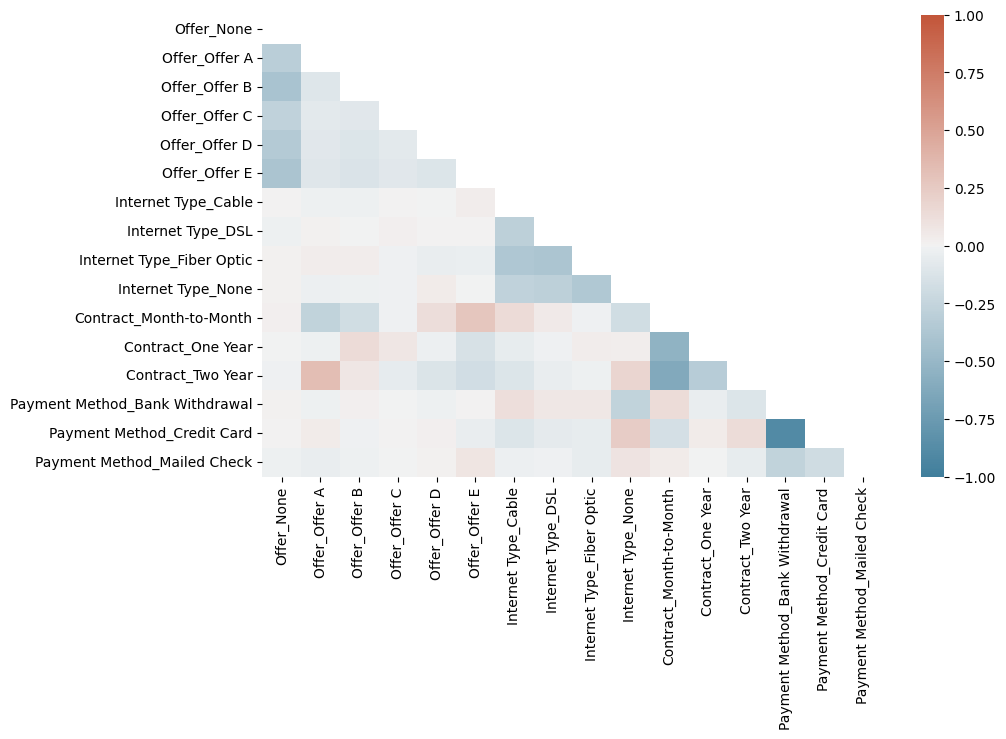

In [20]:
corr = df_onehot_encoder.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=False, vmin=-1, vmax=1)

# 3. Train Logistic model

In [21]:
# Separating the dataset into train and test
X = telco.drop(['Churn Value'], axis=1)
y = telco['Churn Value'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    random_state=222)

## 3.1. Select K best Features

We will attempt to train the model only with the most relevant features of our dataset. To achieve this we will train and test the algorithm with varying combinations of features and compare them using the ROC-AUC metric.

In [22]:
# Select the algorithm to train
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=123)

Classifier Evaluated: LogisticRegression(max_iter=200, random_state=123)


Text(0, 0.5, 'Cross-Validated AUC')

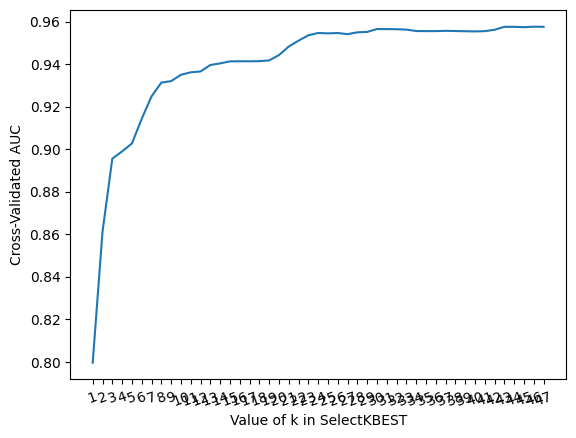

In [23]:
print('Classifier Evaluated: {}'.format(classifier))

k_range = list(range(1, len(X.columns)))
k_scores = []

for k in k_range:
    example_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),          # Imputing missing values with the median
        ('standardscaler', StandardScaler()),                   # Scaling the data using StandardScaler
        ('selector', SelectKBest(k=k)),                         # Selects the best k features of our dataset 
        ('classifier', classifier)])
    score = cross_val_score(example_pipe, X, y, cv=5, scoring='roc_auc').mean()    # Cross val using 5 folds and the score metric is set to AUC
    k_scores.append(score)

k_scores_df = pd.DataFrame({
    'k_range': k_range, 
    'k_scores':k_scores
})

# Plotting the AUC across the different k values
plt.plot(k_range, k_scores)
plt.xlabel('Value of k in SelectKBEST')
plt.xticks(k_range, rotation=20) 
plt.ylabel('Cross-Validated AUC')

The best number of columns is 47 (using all features). However, using so many collumns will take a lot o time to train and will be only slightly better. Looking at the graph, we chose k = 8 because just after 8 the curve starts to flatten. With k = 8, he AUC is approx 0.93 which is 0.02 less than the highest AUC with all of the features.

In [24]:
k_select = 8

pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('standardscaler', StandardScaler()),
        ('selector', SelectKBest(k=k_select)),
        ('classifier', classifier)])
pipe.fit(X_train, y_train)
cols_idxs = pipe[2].get_support(indices=True)               # Mask that indicates which features have been seleccted by the SelectKBest func
best_k_columns = X_train.columns[cols_idxs]

In [25]:
pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selector', SelectKBest(k=8)),
                ('classifier',
                 LogisticRegression(max_iter=200, random_state=123))])

In [26]:
list(best_k_columns)

['Number of Referrals',
 'Tenure in Months',
 'Total Long Distance Charges',
 'Total Customer Svc Requests',
 'Product/Service Issues Reported',
 'Internet Type_Cable',
 'Contract_Month-to-Month',
 'Contract_Two Year']

These are the most relevant features of our dataset.

## 3.2. Data Augmentation

After selecting the best features, we will apply data augumentation to address the imbalance in the Churn category

For this use case we will use the `SMOTE` technique. It is used to address class imbalance by creating synthetic samples for the minority class by interpolating between existing samples, effectively increasing its representation in the dataset.

In [49]:
steps = [SimpleImputer(strategy='median'),      # Imputer
        StandardScaler(),                       # Scaler
        SMOTE(random_state=42),                 # Augmentation
        SelectKBest(k=k_select),                # Selector 
        classifier]                             # Logistic regression

pipe = make_pipeline(*steps)
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('smote', SMOTE(random_state=42)),
                ('selectkbest', SelectKBest(k=8)),
                ('logisticregression',
                 LogisticRegression(max_iter=200, random_state=123))])

# 4. Model Evaluation

The `.predict()` method uses a default threshold of 0.5 to classify predictions into the positive or negative class. However, it is in the company´s best interest to have a threshold different from 0.5 because it will depend on the balance between amount of churners captured and amount of resources invested.

For that reason, we are going to use the `predict_proba()` method, which returns a two-dimensional array, containing the estimated probabilities for each instance and each class: "No Churn" and "Churn"

In [50]:
y_predict = pipe.predict_proba(X_test)

## 4.1. Confusion Matrix

In [51]:
threshold = 0.7 # Manual Threshold 
y_predict_class = [1 if p>threshold else 0 for p in y_predict[:,1]]

The manual threshold will depend on the amount of resources available to prevent churners. In a perfect world, we would spend resources on every single client. However, companies dont have those resources available, so we give them the most significant clients to focus on depending on how much they want to spend. 

The manual threshold of 0.7 is set so that the company can focus on 30% of their most probable churner clients, while having a decent recall of 0.75 (in the churner category) as seen in the classification report that follows. This number can be increased if the company wants to prevent more churners focusing on a higher percentage of their clients.  

With a threshold of 0.7, we "capture" 3 in 4 possible churners.

In [52]:
print(classification_report(y_test, y_predict_class))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1291
           1       0.77      0.75      0.76       470

    accuracy                           0.88      1761
   macro avg       0.84      0.84      0.84      1761
weighted avg       0.87      0.88      0.87      1761



Text(0.5, 25.722222222222214, 'Predicted label')

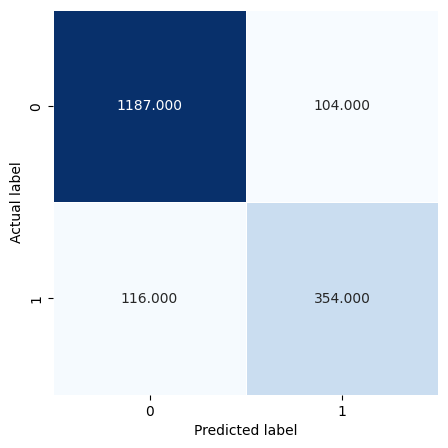

In [53]:
cm = confusion_matrix(y_test, y_predict_class)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues', cbar=False)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 4.2. Probability Distribution

Let's also analyze the probability distribution plot.

With this plot we can clearly see the probability distributions of the classes "Churn" and "Not Churn" and decide on a threshold.

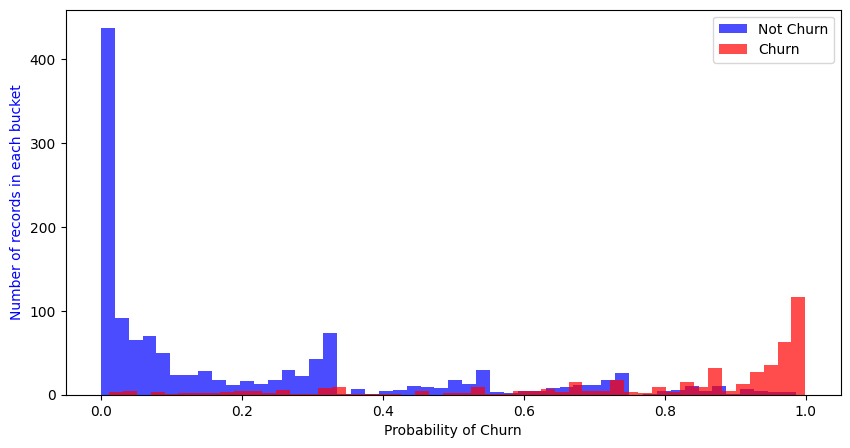

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

l_nch = ax.hist(y_predict[[p==0 for p in y_test]][:,1], bins=50, label='Not Churn', alpha=0.7, color='b')
l_ch  = ax.hist(y_predict[[p==1 for p in y_test]][:,1], bins=50, label='Churn', alpha=0.7, color='r')


ax.set_xlabel('Probability of Churn')
ax.set_ylabel('Number of records in each bucket', color='b')
ax.legend()
plt.show()

## 4.3. ROC Curve 

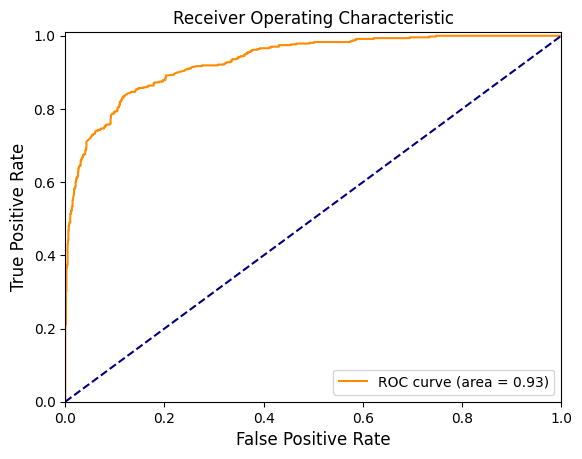

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4.4. Precision-Recall Curve

The ROC curve may not be suitable for imbalanced problems because it focuses on the overall classification performance, which can be misleading when classes are imbalanced. It emphasizes true positive and false positive rates, making the evaluation less informative when the majority class dominates. 
Metrics like precision-recall curve or F1-score are more appropriate for assessing model performance in imbalanced datasets, as they consider the class distribution and prioritize correct predictions for the minority class.

Thus, let's also analyze the precision-recall curve.

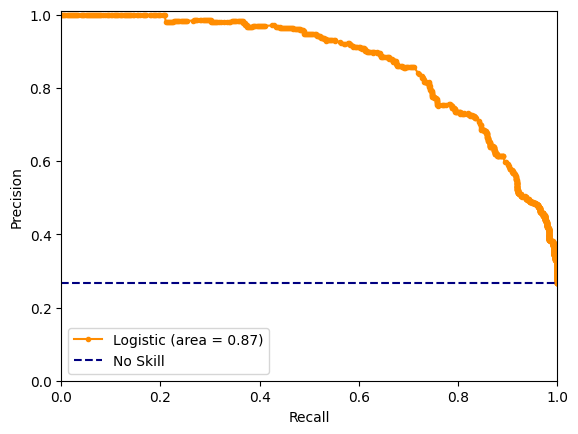

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, y_predict[:, 1])
pr_auc = auc(recall, precision)

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall,precision, marker='.', color='darkorange', label='Logistic (area = %0.2f)' % pr_auc)
plt.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

We can also use this curve to detect and select the threshold we should select in order to have the desired recall level that the company wants.

In [ ]:
recall_wanted=0.8           # Manual recall selection
position_in_array = min(np.where(recall == min(recall[recall>recall_wanted]))[0])
threshold = np.round(thresholds[position_in_array],2)
prec = np.round(precision[position_in_array],2)

print(f'Recall of {recall_wanted} is obtained with a threshold of {threshold} and a precision of {prec}')

Recall of 0.8 is obtained with a threshold of 0.62 and a precision of 0.74


If the company wants to "capture" 80% of possible churners, the threshold will be 0.62 meaning thet they will need to focus on 38% of their customer base.